In [1]:
%config InlineBackend.figure_format='retina'
%matplotlib inline

# Silence warnings
import warnings
warnings.simplefilter(action="ignore", category=FutureWarning)
warnings.simplefilter(action="ignore", category=UserWarning)
warnings.simplefilter(action="ignore", category=RuntimeWarning)
warnings.simplefilter(action='ignore', category=DeprecationWarning)

import numpy as np
np.random.seed(123)
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (8, 8)
plt.rcParams["font.size"] = 14

## Quantile regression with trees

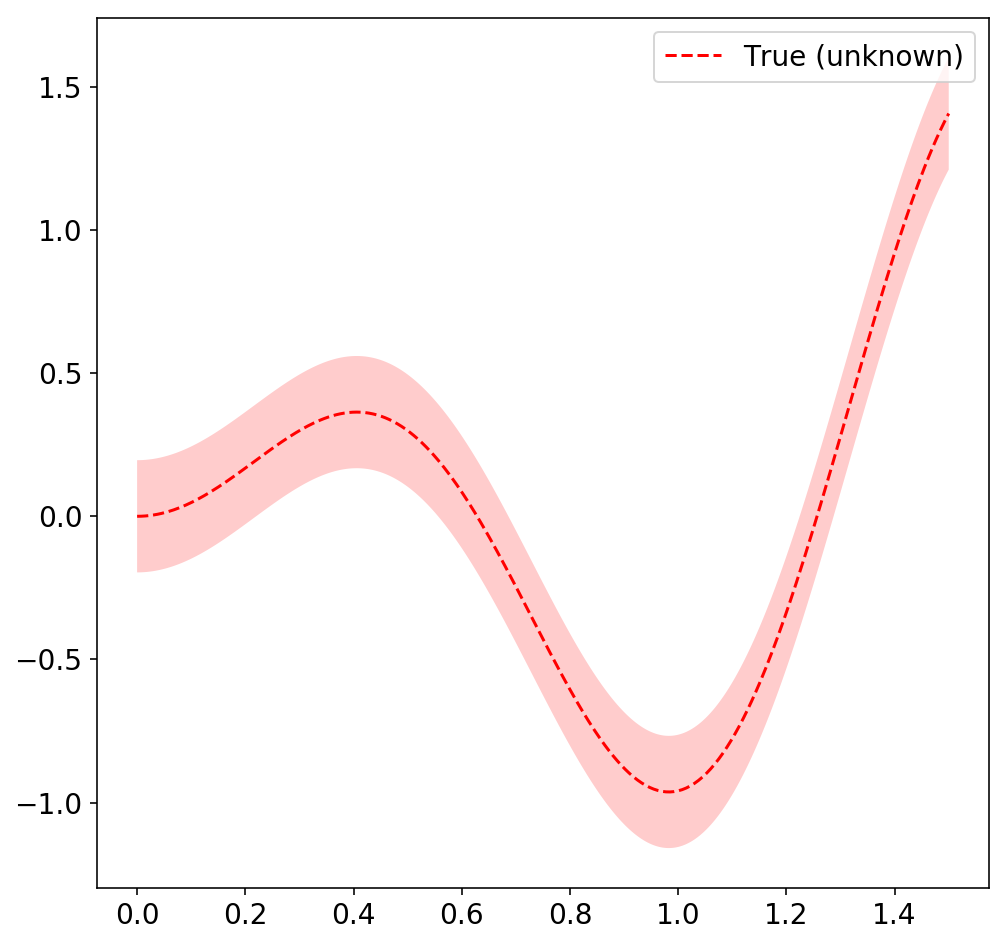

In [2]:
from sklearn.ensemble import GradientBoostingRegressor


noise_level = 0.1

def f(x, noise_level=noise_level):
    return x[0] * np.sin(5 * x[0]) + np.random.randn() * noise_level

x = np.linspace(0, 1.5, 400).reshape(-1, 1)
fx = [f(x_i, noise_level=0.0) for x_i in x]
plt.plot(x, fx, "r--", label="True (unknown)")
plt.fill(np.concatenate([x, x[::-1]]),
         np.concatenate(([fx_i - 1.9600 * noise_level for fx_i in fx], 
                         [fx_i + 1.9600 * noise_level for fx_i in fx[::-1]])),
         alpha=.2, fc="r", ec="None")
plt.legend();

In [3]:
X = np.atleast_2d(np.random.uniform(0, 1.5, size=3000)).T
X = X.astype(np.float32)
y = np.array([f(x_i) for x_i in X])
y = y.reshape(-1, 1)

In [4]:
alpha = 0.95

clf = GradientBoostingRegressor(loss='quantile', alpha=alpha,
                                n_estimators=200, max_depth=3,
                                learning_rate=.05, min_samples_leaf=9,
                                min_samples_split=9)

clf.fit(X, y)

# Make the prediction on the meshed x-axis
y_upper = clf.predict(x)

clf.set_params(alpha=1.0 - alpha)
clf.fit(X, y)

# Make the prediction on the meshed x-axis
y_lower = clf.predict(x)

clf.set_params(alpha=0.5)
clf.fit(X, y)

y_pred = clf.predict(x)

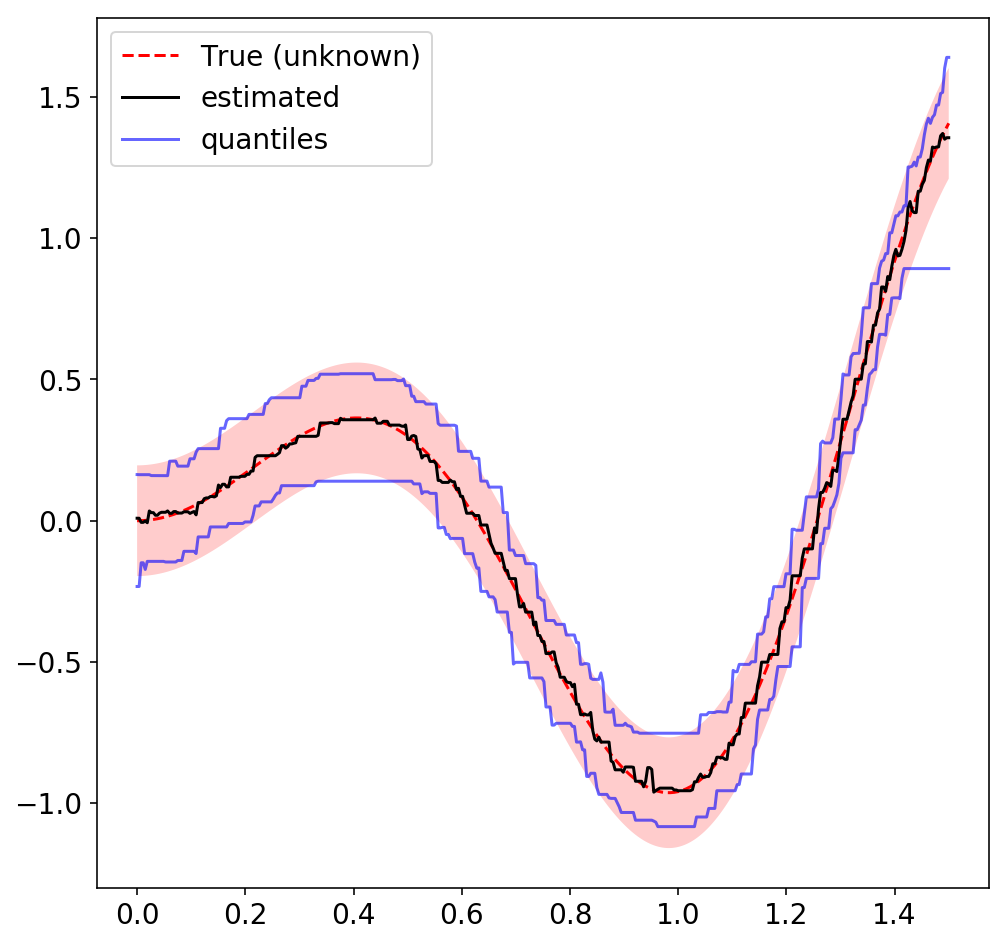

In [5]:
plt.plot(x, fx, "r--", label="True (unknown)")
plt.fill(np.concatenate([x, x[::-1]]),
         np.concatenate(([fx_i - 1.9600 * noise_level for fx_i in fx], 
                         [fx_i + 1.9600 * noise_level for fx_i in fx[::-1]])),
         alpha=.2, fc="r", ec="None")

plt.plot(x, y_pred, 'k', label='estimated')

plt.plot(x, y_lower, 'b-', alpha=0.6, label='quantiles')
plt.plot(x, y_upper, 'b-', alpha=0.6);
plt.legend(loc='best');

---

## Gaussian processes


In [6]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF
# RBF is what sklearn calls the squared exponential kernel

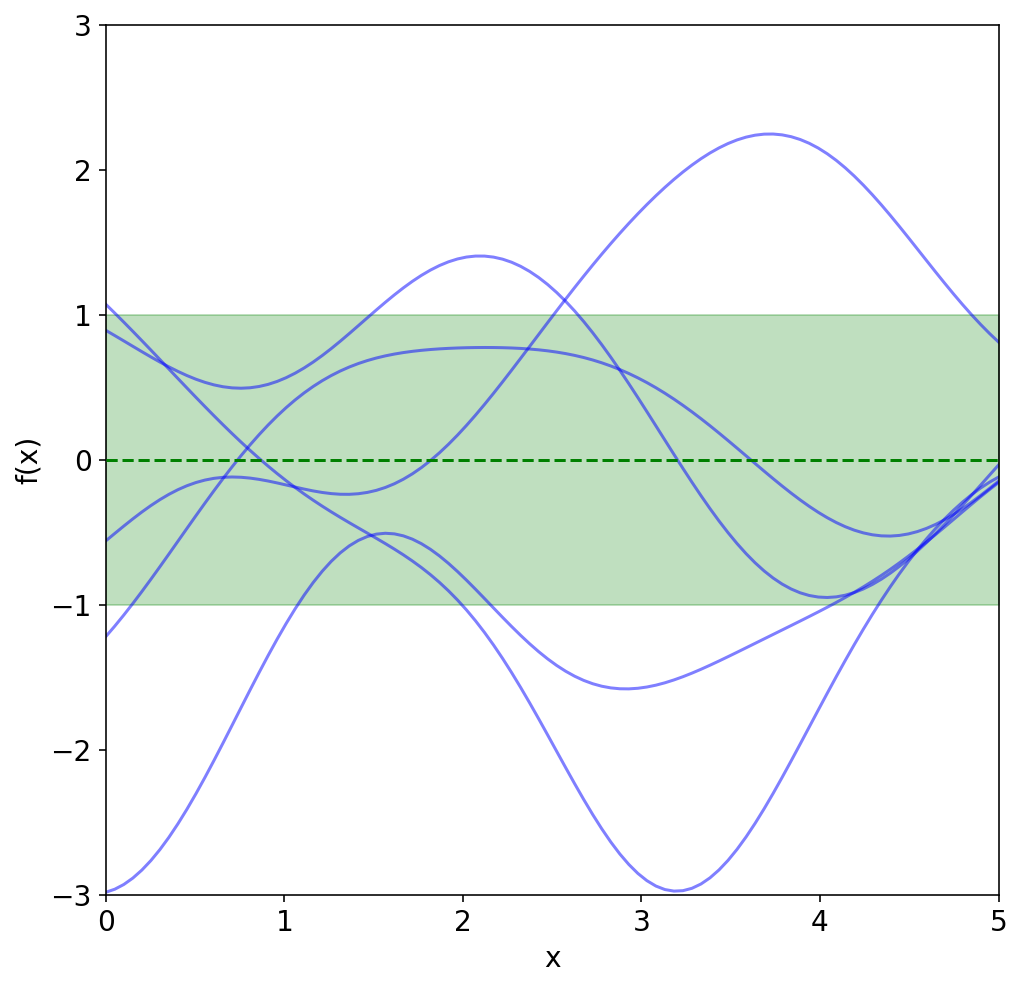

In [7]:
# we have no data yet, so this is the "prior". Why prior?
# With our choice of kernel we specify that near by points should be similar in
# function value. Here we sampled five example "functions" from our GP
# If you kept sampling until infinity you would get the green band.
# Our prior said that the mean of the function is zero, so the dashed green
# line is at zero.
X_ = np.linspace(0, 5, 100)

# try different values here 0.1, 1, 2, 10
kernel = 1.0 * RBF(length_scale=1)
gp = GaussianProcessRegressor(kernel=kernel)

y_mean, y_std = gp.predict(X_[:, np.newaxis], return_std=True)
plt.plot(X_, y_mean, 'g--', zorder=9)
plt.fill_between(X_, y_mean - y_std, y_mean + y_std,
                 alpha=0.25, color='g')

# sample some possible functions
y_samples = gp.sample_y(X_[:, np.newaxis], 5)
plt.plot(X_, y_samples, "b", alpha=0.5)
plt.xlim(0, 5)
plt.ylim(-3, 3)
plt.xlabel("x")
plt.ylabel("f(x)");

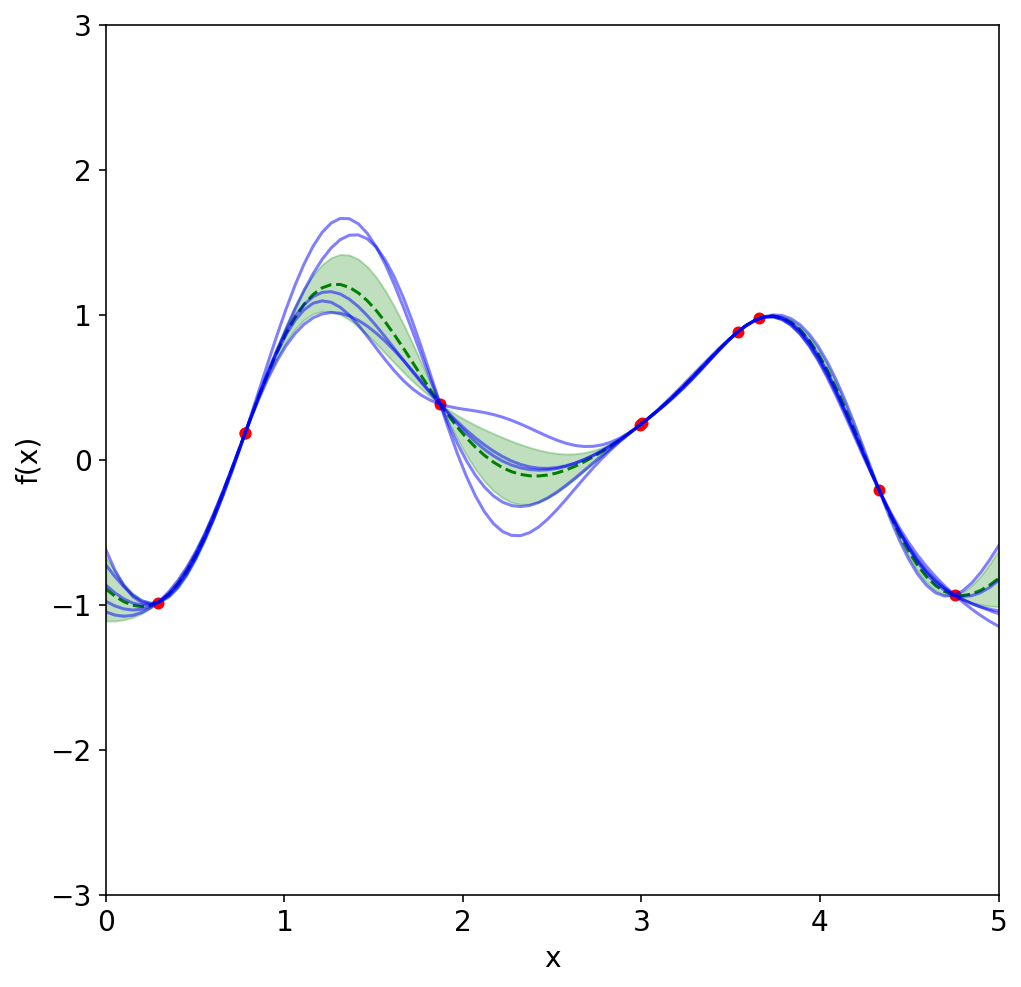

In [8]:
# Plot posterior. We now have data that our GP has fitted. There are less
# possible functions that fit the data. All functions pass through the data
# points, green bands appear only when we are far away from the data points.

# sample some data points
rng = np.random.RandomState(42)
X = rng.uniform(0, 5, 10)
X = X.reshape(-1, 1)
y = np.sin((X[:, 0] - 2.5) ** 2)

# fit our GP
kernel = 1.0 * RBF(length_scale=0.01)
gp = GaussianProcessRegressor(kernel=kernel)
gp.fit(X, y)

y_mean, y_std = gp.predict(X_[:, np.newaxis], return_std=True)
plt.plot(X_, y_mean, 'g--')
plt.fill_between(X_, y_mean - y_std, y_mean + y_std, alpha=0.25, color='g')

# some possible functions
y_samples = gp.sample_y(X_[:, np.newaxis], 5)
plt.plot(X_, y_samples, "b", alpha=0.5)
plt.scatter(X[:, 0], y, c='r', linewidths=0)
plt.xlim(0, 5)
plt.ylim(-3, 3)
plt.xlabel("x")
plt.ylabel("f(x)");

0.539**2 * RBF(length_scale=0.578)


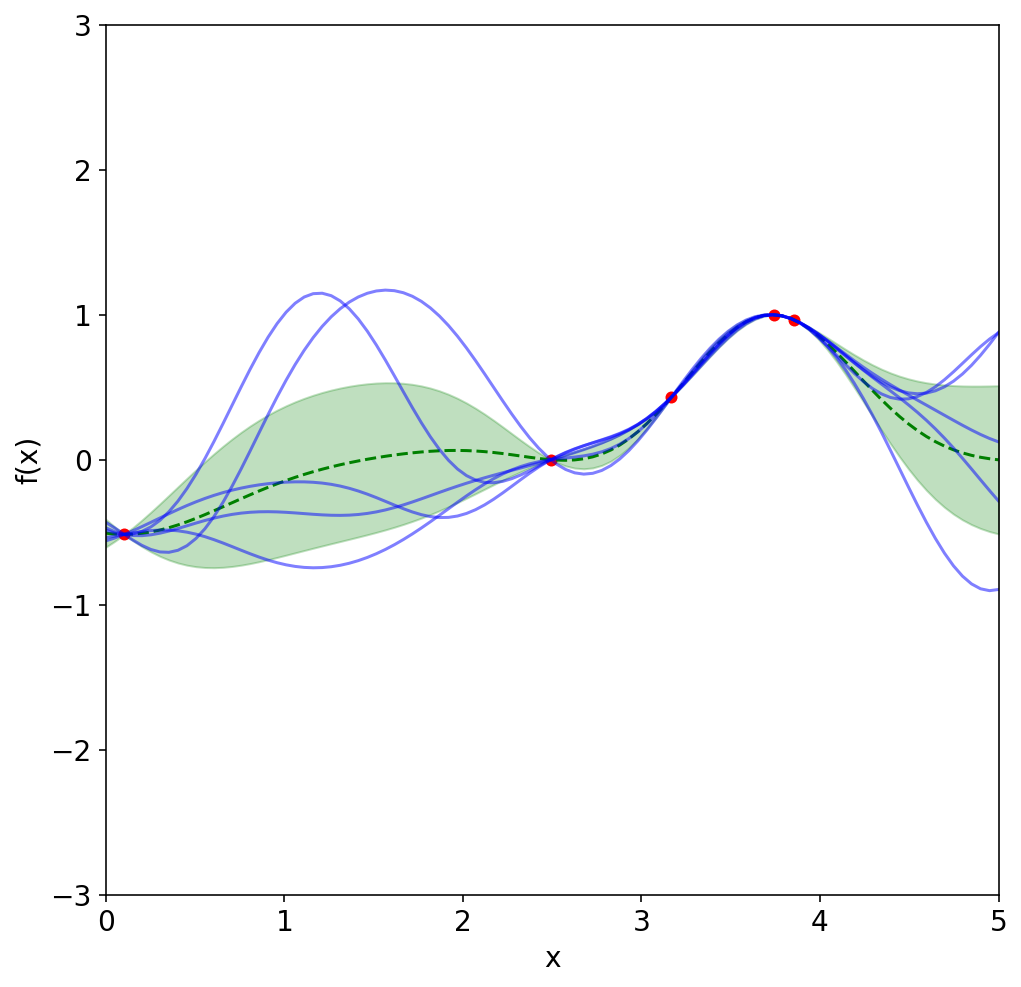

In [9]:
# the kernel uses maximum likelihood to fit the parameters of the kernel
# sample some data points
rng = np.random.RandomState(10)
X = rng.uniform(0, 5, 5)
X = X.reshape(-1, 1)
y = np.sin((X[:, 0] - 2.5) ** 2)

# fit our GP
kernel = 1.0 * RBF()
gp = GaussianProcessRegressor(kernel=kernel)
gp.fit(X, y)

print(gp.kernel_)

# Plot posterior
y_mean, y_std = gp.predict(X_[:, np.newaxis], return_std=True)
plt.plot(X_, y_mean, 'g--')
plt.fill_between(X_, y_mean - y_std, y_mean + y_std, alpha=0.25, color='g')

# some possible functions
y_samples = gp.sample_y(X_[:, np.newaxis], 5)
plt.plot(X_, y_samples, "b", alpha=0.5)
plt.scatter(X[:, 0], y, c='r', linewidths=0)
plt.xlim(0, 5)
plt.ylim(-3, 3)
plt.xlabel("x")
plt.ylabel("f(x)");

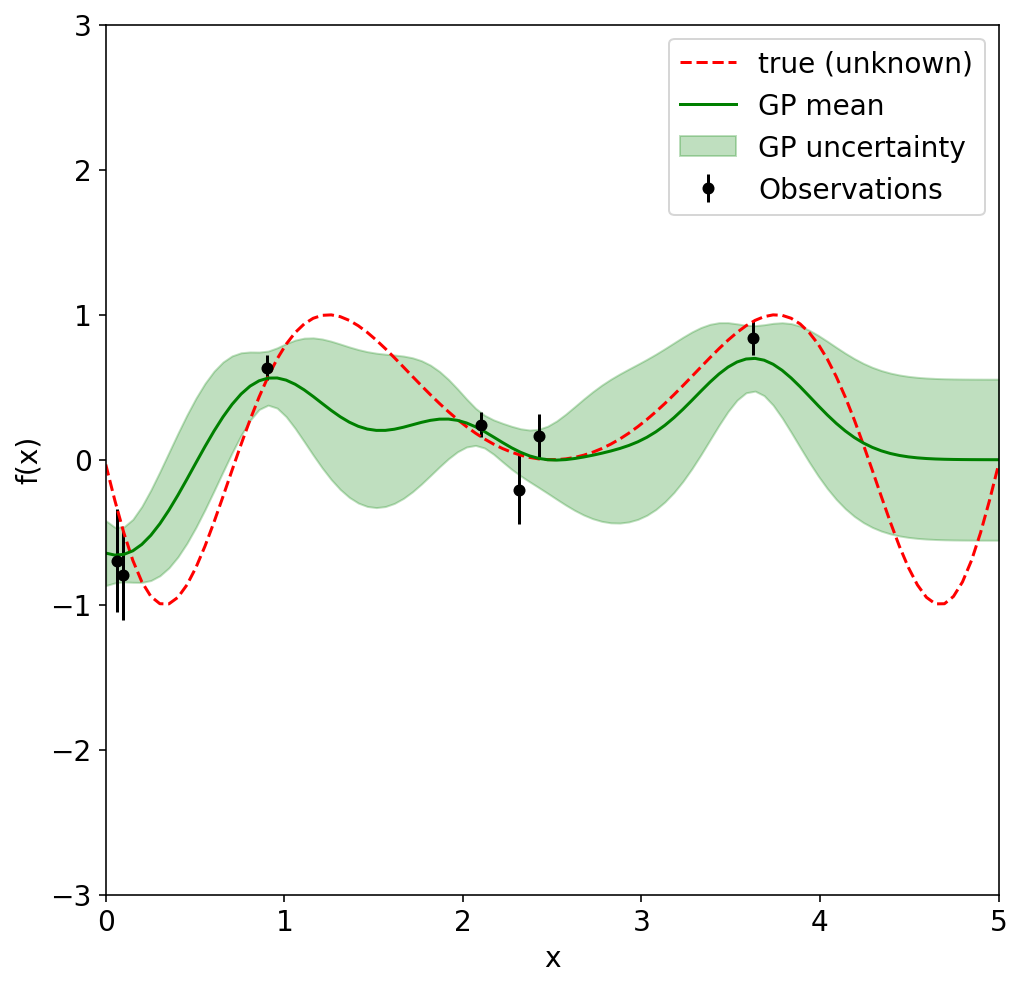

In [10]:
# What about noisy observations?

rng = np.random.RandomState(11)
X = rng.uniform(0, 5, 7)
X = X.reshape(-1, 1)
y = np.sin((X[:, 0] - 2.5) ** 2)
dy =  0.1 + rng.uniform(0, 0.2, y.shape)
noise = rng.normal(0, dy, y.shape)
y += noise

# specify some noise level along the diagonal
kernel = 1.0 * RBF()
gp = GaussianProcessRegressor(kernel=kernel, alpha=dy**2)
# fit our GP
gp.fit(X, y)

y_mean, y_std = gp.predict(X_[:, np.newaxis], return_std=True)
plt.plot(X_, np.sin((X_ - 2.5) ** 2), 'r--', label='true (unknown)')
plt.plot(X_, y_mean, 'g-', label='GP mean')
plt.fill_between(X_, y_mean - y_std, y_mean + y_std, alpha=0.25, color='g',
                 label='GP uncertainty')
plt.errorbar(X[:, 0], y, noise, fmt='k.', markersize=10, label='Observations')

plt.xlim(0, 5)
plt.ylim(-3, 3)
plt.xlabel("x")
plt.ylabel("f(x)");
plt.legend(loc='best');

### Priors, posteriors and more

http://scikit-learn.org/stable/auto_examples/gaussian_process/plot_gpr_prior_posterior.html#sphx-glr-auto-examples-gaussian-process-plot-gpr-prior-posterior-py